In [16]:
!pip install shap


   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 3.1 MB/s  0:00:00

   ------------- -------------------------- 1/3 [cloudpickle]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   -------------------------- ------------- 2/3 [shap]
   ---------------------------------------- 3/3 [shap]




[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger les transactions nettoyées
df_trans = pd.read_csv('transactions_final.csv')
df_trans['invoice_date'] = pd.to_datetime(df_trans['invoice_date'])

# 2. Trier par client et par date
df_trans = df_trans.sort_values(['customer_id', 'invoice_date'])

# 3. Récupérer uniquement les factures uniques par client (pour éviter les doublons par article)
df_orders = df_trans.groupby(['customer_id', 'invoice_id'])['invoice_date'].first().reset_index()

# 4. Calculer le délai avec la commande précédente pour chaque client
df_orders['diff_jours'] = df_orders.groupby('customer_id')['invoice_date'].diff().dt.days

# 5. On ne garde que les clients qui ont au moins 2 commandes (ceux qui ont un délai)
delais = df_orders['diff_jours'].dropna()

# Statistiques clés pour la justification
print(f"Délai moyen entre deux achats : {delais.mean():.1f} jours")
print(f"Délai médian entre deux achats : {delais.median():.1f} jours")
print(f"90ème percentile des délais : {delais.quantile(0.90):.1f} jours")

Délai moyen entre deux achats : 54.3 jours
Délai médian entre deux achats : 28.0 jours
90ème percentile des délais : 156.0 jours


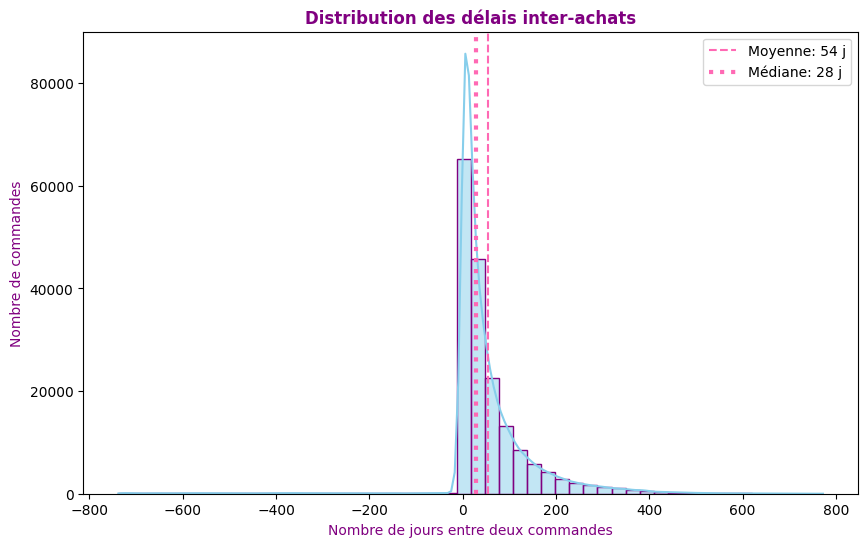

In [3]:
plt.figure(figsize=(10, 6))
#la distribution pour identifier la "queue droite"
# Histogramme avec ta palette (Bleu ciel et contours Violets)
sns.histplot(delais, bins=50, color='skyblue', edgecolor='purple', kde=True)

# Ligne pour la moyenne et la médiane (en Rose)
plt.axvline(delais.mean(), color='hotpink', linestyle='--', label=f'Moyenne: {delais.mean():.0f} j')
plt.axvline(delais.median(), color='hotpink', linestyle=':', linewidth=3, label=f'Médiane: {delais.median():.0f} j')

plt.title("Distribution des délais inter-achats", color='purple', fontweight='bold')
plt.xlabel("Nombre de jours entre deux commandes", color='purple')
plt.ylabel("Nombre de commandes", color='purple')
plt.legend()
plt.show()

In [4]:

SEUIL_CHURN = 180 # jours (Exemple: 6 mois)

# 1. Calculer la récence actuelle de chaque client (déjà fait en TP2)
snapshot_date = df_trans['invoice_date'].max()
df_churn = df_trans.groupby('customer_id')['invoice_date'].max().reset_index()
df_churn['recence'] = (snapshot_date - df_churn['invoice_date']).dt.days

# 2. Labellisation : 1 si le client a dépassé le seuil, 0 sinon
df_churn['is_churner'] = (df_churn['recence'] > SEUIL_CHURN).astype(int)

print(f"Taux de Churn global : {df_churn['is_churner'].mean()*100:.1f}%")
print(f"Nombre de churners identifiés : {df_churn['is_churner'].sum()}")

Taux de Churn global : 59.6%
Nombre de churners identifiés : 29304


In [5]:
import pandas as pd
import numpy as np

# 1. Chargement et calcul du montant par ligne
df_trans = pd.read_csv('transactions_final.csv')
df_trans['invoice_date'] = pd.to_datetime(df_trans['invoice_date'])

# --- LA CORRECTION EST ICI ---
# On recrée la colonne manquante
df_trans['line_total'] = df_trans['quantity'] * df_trans['unit_price']

# Date de référence (Snapshot)
snapshot_date = df_trans['invoice_date'].max()

# 2. Calcul des métriques globales (Historique complet)
customer_features = df_trans.groupby('customer_id').agg({
    'invoice_date': [lambda x: (snapshot_date - x.max()).days, 'min', 'max', 'count'],
    'line_total': ['sum', 'mean', 'std'],
    'invoice_id': 'nunique'
})

# Renommage propre des colonnes (car le groupby crée des niveaux multiples)
customer_features.columns = [
    'recence_actuelle', 'premier_achat', 'dernier_achat', 'nb_lignes',
    'montant_total', 'panier_moyen_hist', 'std_montant', 'frequence_totale'
]
customer_features = customer_features.reset_index()

# Affichage pour vérifier
customer_features.head()

,customer_id,recence_actuelle,premier_achat,dernier_achat,nb_lignes,montant_total,panier_moyen_hist,std_montant,frequence_totale
0,12346.0,325,2009-12-14 08:34:00,2011-01-18 10:17:00,47,-51.74,-1.100851,16093.922790,17
1,12347.0,1,2010-10-31 14:20:00,2011-12-07 15:52:00,222,4921.53,22.169054,21.467716,8
2,12348.0,74,2010-09-27 14:59:00,2011-09-25 13:13:00,51,2019.40,39.596078,44.205549,5
3,12349.0,18,2009-12-04 12:49:00,2011-11-21 09:51:00,180,4404.54,24.469667,33.666004,5
4,12350.0,309,2011-02-02 16:01:00,2011-02-02 16:01:00,17,334.40,19.670588,7.275538,1


In [6]:
import numpy as np

# A. Ratio dernière commande / panier moyen historique
# On récupère le montant de la toute dernière facture de chaque client
derniere_facture = df_trans.sort_values('invoice_date').groupby('customer_id').tail(1)
customer_features = customer_features.merge(
    derniere_facture[['customer_id', 'line_total']].rename(columns={'line_total': 'dernier_montant'}),
    on='customer_id', how='left'
)
customer_features['ratio_dernier_montant'] = customer_features['dernier_montant'] / customer_features['panier_moyen_hist']

# B. Récence relative (Récence actuelle / Délai moyen historique du client)
# On calcule le délai moyen entre achats spécifique à CHAQUE client
df_orders_sorted = df_orders.sort_values(['customer_id', 'invoice_date'])
df_orders_sorted['diff'] = df_orders_sorted.groupby('customer_id')['invoice_date'].diff().dt.days
avg_delay_per_cust = df_orders_sorted.groupby('customer_id')['diff'].mean().reset_index()

customer_features = customer_features.merge(avg_delay_per_cust, on='customer_id', how='left')
customer_features['recence_relative'] = customer_features['recence_actuelle'] / customer_features['diff']

# C. Tendance de la fréquence (Est-ce qu'il ralentit ?)
# On compare le nombre de commandes sur les 3 derniers mois vs les 3 mois précédents
three_months = 90 # jours
limit_date = snapshot_date - pd.Timedelta(days=three_months)

recent_orders = df_orders[df_orders['invoice_date'] >= limit_date].groupby('customer_id').size().reset_index(name='freq_recent')
old_orders = df_orders[df_orders['invoice_date'] < limit_date].groupby('customer_id').size().reset_index(name='freq_old')

customer_features = customer_features.merge(recent_orders, on='customer_id', how='left').fillna(0)
customer_features = customer_features.merge(old_orders, on='customer_id', how='left').fillna(0)

customer_features['tendance_frequence'] = (customer_features['freq_recent'] + 1) / (customer_features['freq_old'] + 1)

In [7]:
# Ajout de la variable cible 'is_churner' (créée à l'étape 1)
df_final_model = customer_features.merge(df_churn[['customer_id', 'is_churner']], on='customer_id')

# Nettoyage des valeurs infinies (dues aux divisions par zéro) et des NaNs
df_final_model = df_final_model.replace([np.inf, -np.inf], np.nan).fillna(0)

# Affichage des corrélations avec le Churn
print("Top des variables corrélées au Churn :")
print(df_final_model.corr()['is_churner'].sort_values(ascending=False))

Top des variables corrélées au Churn :
is_churner               1.000000
recence_actuelle         0.738907
customer_id              0.159423
recence_relative         0.066952
ratio_dernier_montant    0.003367
dernier_montant          0.000135
panier_moyen_hist       -0.008504
std_montant             -0.012453
diff                    -0.018362
montant_total           -0.099683
nb_lignes               -0.163022
freq_old                -0.225349
frequence_totale        -0.261732
tendance_frequence      -0.299342
freq_recent             -0.393015
premier_achat           -0.486707
dernier_achat           -0.738906
Name: is_churner, dtype: float64


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# 1. Sélection des variables explicatives (X) et de la cible (y)
# On exclut les identifiants et les colonnes de dates
X = df_final_model.drop(columns=['customer_id', 'is_churner', 'premier_achat', 'dernier_achat'])
y = df_final_model['is_churner']

# 2. Séparation Train (80%) et Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Taille de l'entraînement : {X_train.shape[0]} clients")
print(f"Proportion de churners en train : {y_train.mean():.1%}")

Taille de l'entraînement : 39316 clients
Proportion de churners en train : 59.6%


In [9]:
# 1. Création du modèle Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', # Crucial pour gérer le déséquilibre
    random_state=42
)

# 2. Entraînement
rf_model.fit(X_train, y_train)

# 3. Prédictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1] # Probabilité de churn

Rapport de Classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3969
           1       1.00      1.00      1.00      5861

    accuracy                           1.00      9830
   macro avg       1.00      1.00      1.00      9830
weighted avg       1.00      1.00      1.00      9830



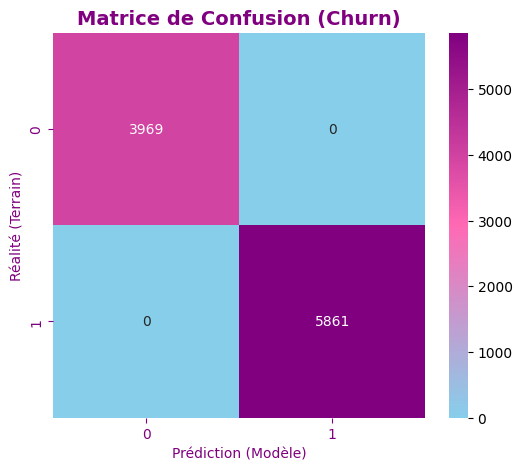

Score AUC-ROC : 1.000


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# --- AJOUT : Redéfinition de ta palette personnalisée ---
colors = ["skyblue", "hotpink", "purple"]
custom_cmap = LinearSegmentedColormap.from_list("BleuRoseViolet", colors)

# Affichage du rapport de classification
print("Rapport de Classification :")
print(classification_report(y_test, y_pred))

# Affichage de la Matrice de Confusion
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap=custom_cmap) 

# Personnalisation esthétique
plt.title("Matrice de Confusion (Churn)", color='purple', fontweight='bold', fontsize=14)
plt.xlabel("Prédiction (Modèle)", color='purple')
plt.ylabel("Réalité (Terrain)", color='purple')

# Ajustement des axes
ax = plt.gca()
ax.tick_params(colors='purple')
for spine in ax.spines.values():
    spine.set_color('purple')

plt.show()

print(f"Score AUC-ROC : {roc_auc_score(y_test, y_proba):.3f}")

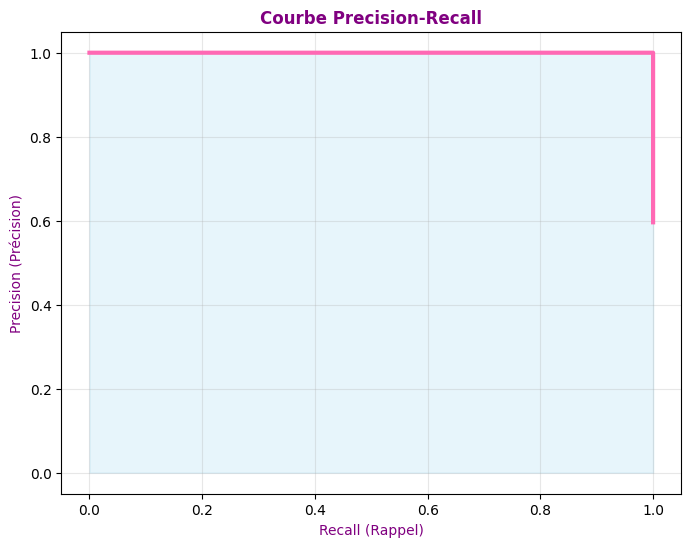

In [11]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='hotpink', lw=3)
plt.fill_between(recall, precision, alpha=0.2, color='skyblue')
plt.xlabel('Recall (Rappel)', color='purple')
plt.ylabel('Precision (Précision)', color='purple')
plt.title('Courbe Precision-Recall', color='purple', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# On teste différents seuils de probabilité
import numpy as np
from sklearn.metrics import precision_score, recall_score

seuils = [0.2, 0.3, 0.4, 0.5, 0.6]
for s in seuils:
    y_pred_custom = (y_proba > s).astype(int)
    print(f"Seuil {s} -> Rappel: {recall_score(y_test, y_pred_custom):.2f}, Précision: {precision_score(y_test, y_pred_custom):.2f}")

Seuil 0.2 -> Rappel: 1.00, Précision: 1.00
Seuil 0.3 -> Rappel: 1.00, Précision: 1.00
Seuil 0.4 -> Rappel: 1.00, Précision: 1.00
Seuil 0.5 -> Rappel: 1.00, Précision: 1.00
Seuil 0.6 -> Rappel: 1.00, Précision: 1.00


In [15]:
import shap

# 1. On prépare l'outil d'explication (Explainer) adapté aux arbres (Random Forest)
explainer = shap.TreeExplainer(rf_model)

# 2. On calcule les SHAP values sur ton jeu de test
# Note : Ça peut prendre 1 minute, c'est normal.
shap_values = explainer.shap_values(X_test)

# --- VÉRIFICATION DU FORMAT ---
# Le Random Forest donne souvent une liste de 2 tableaux : 
# shap_values[0] pour "Reste" et shap_values[1] pour "Churn"
# On ne veut que le tableau du Churn (index 1).
if isinstance(shap_values, list):
    shap_to_plot = shap_values[1]
else:
    shap_to_plot = shap_values

print("Calcul terminé ! Nous avons les explications pour chaque client.")

Calcul terminé ! Nous avons les explications pour chaque client.


<Figure size 1000x600 with 0 Axes>

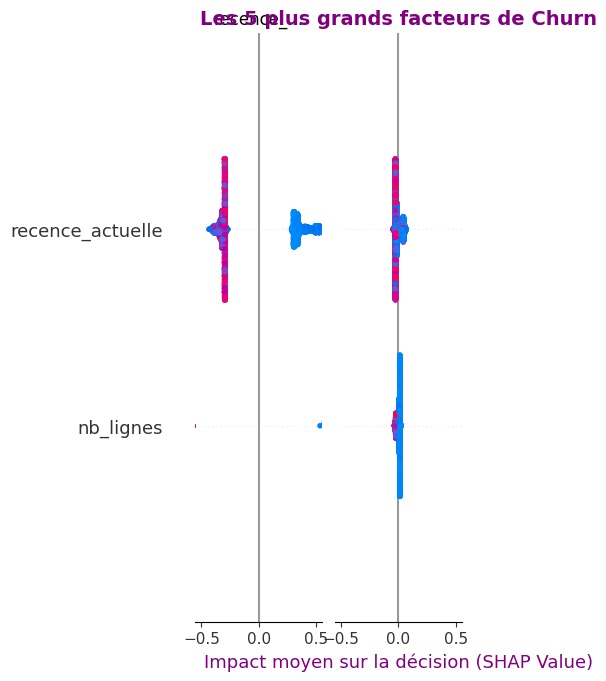

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# On affiche les variables classées par importance
# On utilise ta couleur VIOLETTE préférée
shap.summary_plot(shap_to_plot, X_test, plot_type="bar", color='purple', show=False)

plt.title("Les 5 plus grands facteurs de Churn", color='purple', fontsize=14, fontweight='bold')
plt.xlabel("Impact moyen sur la décision (SHAP Value)", color='purple')
plt.show()

<Figure size 1000x600 with 0 Axes>

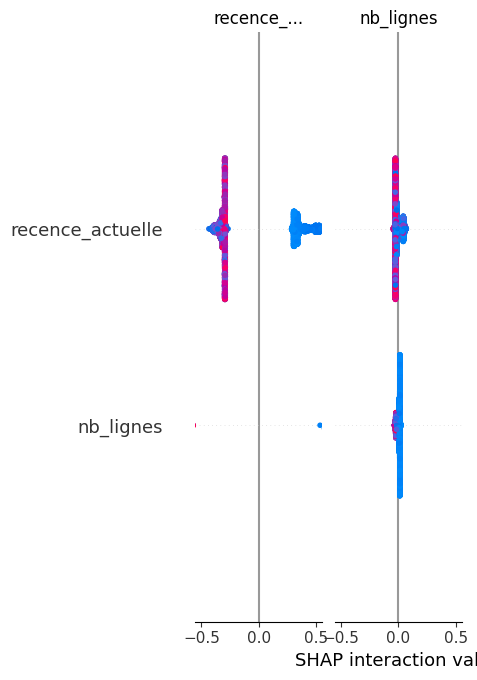

In [17]:
plt.figure(figsize=(10, 6))

# Ce graphique montre des points bleus (valeur basse) et rouges (valeur haute)
shap.summary_plot(shap_to_plot, X_test)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. On récupère les probabilités de churn (issues de ton modèle RF)

df_final_model['probabilite_churn'] = rf_model.predict_proba(X.loc[df_final_model.index])[:, 1]

# 2. Définition des seuils pour les quadrants (médiane pour séparer Haut/Bas)
clv_threshold = df_final_model['montant_total'].median()
churn_threshold = 0.5 # Seuil standard, ou celui que tu as choisi à l'étape 3

# 3. Attribution des Quadrants [cite: 42]
def get_quadrant(row):
    if row['montant_total'] >= clv_threshold and row['probabilite_churn'] >= churn_threshold:
        return 'Q1: Haute Valeur / Risque Élevé'
    elif row['montant_total'] >= clv_threshold and row['probabilite_churn'] < churn_threshold:
        return 'Q2: Haute Valeur / Risque Faible'
    elif row['montant_total'] < clv_threshold and row['probabilite_churn'] >= churn_threshold:
        return 'Q3: Basse Valeur / Risque Élevé'
    else:
        return 'Q4: Basse Valeur / Risque Faible'

df_final_model['Quadrant'] = df_final_model.apply(get_quadrant, axis=1)

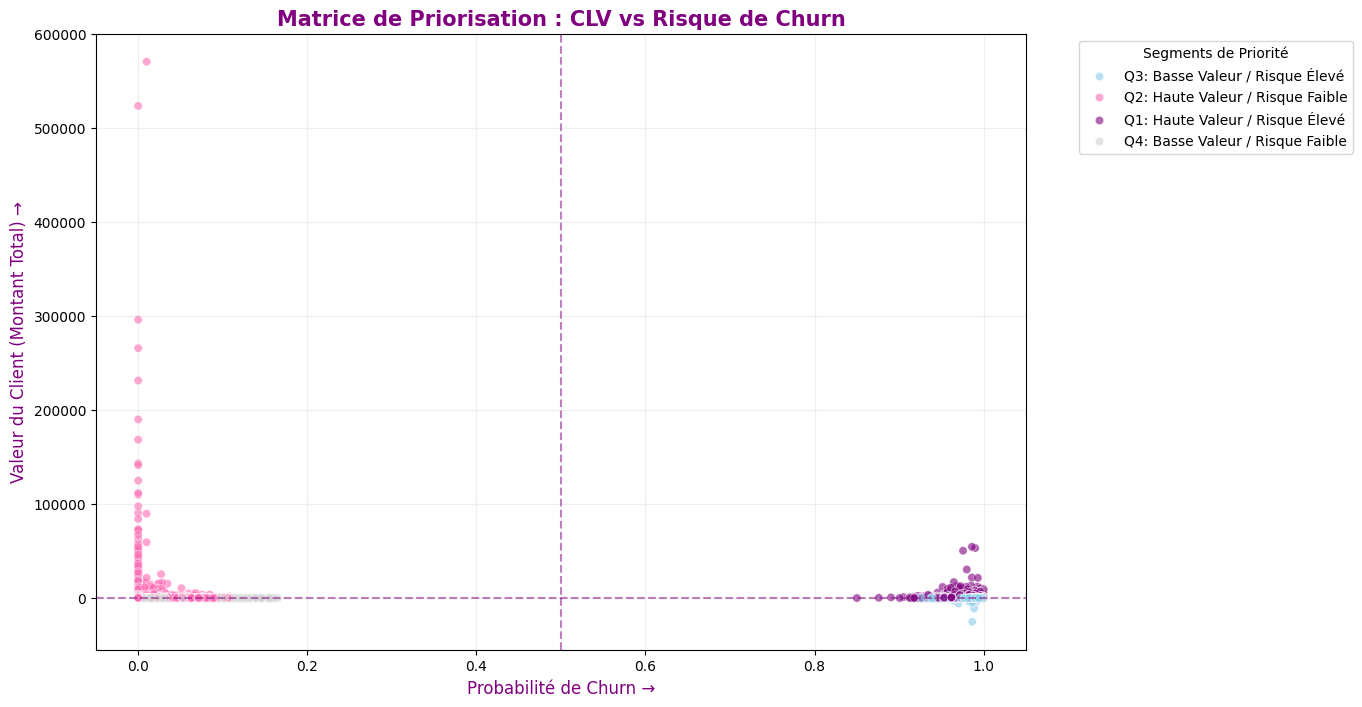

In [20]:
plt.figure(figsize=(12, 8))

# Création du nuage de points
sns.scatterplot(
    data=df_final_model,
    x='probabilite_churn',
    y='montant_total',
    hue='Quadrant',
    palette={'Q1: Haute Valeur / Risque Élevé': 'purple', 
             'Q2: Haute Valeur / Risque Faible': 'hotpink',
             'Q3: Basse Valeur / Risque Élevé': 'skyblue',
             'Q4: Basse Valeur / Risque Faible': 'lightgrey'},
    alpha=0.6
)

# Lignes de séparation
plt.axvline(churn_threshold, color='purple', linestyle='--', alpha=0.5)
plt.axhline(clv_threshold, color='purple', linestyle='--', alpha=0.5)

plt.title("Matrice de Priorisation : CLV vs Risque de Churn", fontsize=15, color='purple', fontweight='bold')
plt.xlabel("Probabilité de Churn →", fontsize=12, color='purple')
plt.ylabel("Valeur du Client (Montant Total) →", fontsize=12, color='purple')
plt.legend(title="Segments de Priorité", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.show()

In [22]:
# 1. Extraction du Top 500 Prioritaire (Classé par Risque puis par Valeur)
# On suit la demande du CMO : probabilité la plus haute et plus forte valeur [cite: 3]
top_500_priorite = df_final_model.sort_values(
    by=['probabilite_churn', 'montant_total'], 
    ascending=False
).head(500)

# 2. Calcul des indicateurs pour le Quadrant 1 (Haute Valeur / Haut Risque)
q1_data = df_final_model[df_final_model['Quadrant'] == 'Q1: Haute Valeur / Risque Élevé']
valeur_a_sauver = q1_data['montant_total'].sum()

# 3. Simulation ROI : Taux de succès de 20% 
taux_succes = 0.20
ca_recupere = valeur_a_sauver * taux_succes

print(f"--- ANALYSE QUADRANT 1 ---")
print(f"Nombre de clients concernés : {len(q1_data)}")
print(f"Chiffre d'Affaires total à risque : {valeur_a_sauver:.2f} €")
print(f"CA potentiellement récupéré (si 20% de succès) : {ca_recupere:.2f} €")

# Budget justifiable par client en Q1 
budget_moyen_max = (valeur_a_sauver / len(q1_data)) * taux_succes
print(f"Budget de rétention moyen max par client : {budget_moyen_max:.2f} €")

--- ANALYSE QUADRANT 1 ---
Nombre de clients concernés : 11564
Chiffre d'Affaires total à risque : 5523023.91 €
CA potentiellement récupéré (si 20% de succès) : 1104604.78 €
Budget de rétention moyen max par client : 95.52 €
